Notebook purpose: evaluate how efficiently we could search for catalysts using the ML model under various constraints.

The most conspicuous constraint is to find a set number of active catalysts without any unnecessary DFT calculations
What is unnecessary? --> 100% of O2 binding calculations are to actual binding sites
So we can accept a model with lower accuracy as long as it has no false positives --> only a small penalty for false negatives

Let's say we're only willing to run 5 DFT O2 binding calculations, and we want basically all of them to show that we found active sites. We'd probably want each of these to be per catalyst, to show that we've found 5 unique active catalysts. Assuming we're working with 10% of the data as a "test" set, that's about 27 calalysts, so we want to pick the ones that the model is most confident have at least 1 site that binds O2.

Really, this is a question of whether the active sites for a set of catalysts are most likely to actually be binding
Can order by log-loss and take that as an estimate of uncertainty (is that a fair expectation?)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor

plt.rcParams.update({'font.size': 20})

In [2]:
from ngcc_ml import data_tools
from ngcc_ml import skl_tools

In [3]:
def group_regression_kfold_evaluate(model, df_xy, feature_cols, target_col="BindingEnergy", n_splits=10, group_col="Catalyst Name"):
    all_mae, all_mse, all_test = [], [], []
    split_groups = GroupKFold(n_splits=n_splits).split(df_xy[feature_cols], df_xy[target_col], df_xy[group_col])
    for train_inds, test_inds in split_groups:
        model_kfg = clone(model)
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group = train[feature_cols]
        X_test_group = test[feature_cols]
        y_test_group = test[target_col]
        y_train_group = train[target_col]
        model_kfg.fit(X_train_group, y_train_group)
        score = model_kfg.score(X_test_group, y_test_group)
        y_test_group_pred = model_kfg.predict(X_test_group)
        test = test.assign(BindingEnergy_pred=y_test_group_pred)
        mse = mean_squared_error(y_test_group, y_test_group_pred)
        mae = mean_absolute_error(y_test_group, y_test_group_pred)
        all_test.append(test)
        all_mae.append(mae)
        all_mse.append(mse)

        print('MAE of MLP on test set: {:.4f}'.format(mae))
    print("mean:", np.mean(all_mae))
    print("stdev:", np.std(all_mae))
    df_pred_aug = pd.concat(all_test)
    return all_mse, all_mae, df_pred_aug


In [4]:
df = pd.read_csv("/home/nricke/work/ngcc_ml/DidItBindv5.csv")
df["Doesitbind"] = df["Doesitbind"].astype("int")
df_inactive = df[df["Doesitbind"] == 0]
df_spec = df.copy()
# set to 0 if it doesn't bind
df_spec.loc[df_spec['Doesitbind'] == 0, 'BindingEnergy'] = 0.0
df = df[df["Doesitbind"] == 1]

In [14]:
df.columns

Index(['Unnamed: 0', 'Atom Number', 'Catalyst Name', 'CatalystO2File',
       'Element', 'SpinDensity', 'ChElPGPositiveCharge', 'ChElPGNeutralCharge',
       'ChargeDifference', 'Doesitbind', 'BondLength', 'IonizedFreeEnergy',
       'IonizationEnergy', 'BindingEnergy', 'NeutralFreeEnergy', 'OrthoOrPara',
       'Meta', 'FartherThanPara', 'DistanceToN', 'AverageBondLength',
       'BondLengthRange', 'NumberOfHydrogens', 'AromaticSize', 'IsInRingSize6',
       'IsInRingSize5', 'NeighborSpinDensity', 'NeighborChElPGCharge',
       'NeighborChargeDifference', 'AromaticExtent', 'RingEdge',
       'NumNitrogens', 'NumHeteroatoms', 'ring_nitrogens',
       'atom_plane_deviation', 'ring_plane_deviation', 'charge'],
      dtype='object')

(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 1.300e+01, 4.000e+00, 1.200e+01, 2.000e+01, 2.000e+01,
        2.800e+01, 2.500e+01, 1.700e+01, 3.200e+01, 2.800e+01, 3.100e+01,
        2.100e+01, 4.600e+01, 3.000e+01, 4.200e+01, 2.900e+01, 2.300e+01,
        2.200e+01, 2.000e+01, 2.700e+01, 3.000e+01, 2.900e+01, 3.300e+01,
        2.100e+01, 3.100e+01, 3.300e+01, 4.200e+01, 1.300e+01, 0.000e+00,
        0.000e+00, 3.402e+03]),
 array([-1.37867253, -1.35109908, -1.32352562, -1.29595217, -1.26837872,
        -1.24080527, -1.21323182, -1.18565837, -1.15808492, -1.13051147,
        -1.10293802, -1.07536457, -1.04779112, -1.02021767, -0.99264422,
        -0.96507077, -0.93749732, -0.90992387, -0.88235042, -0.85477697,
        -0.82720352, -0.79963007, -0.77205661, -0.74448316, -0.71690971,
        -0.

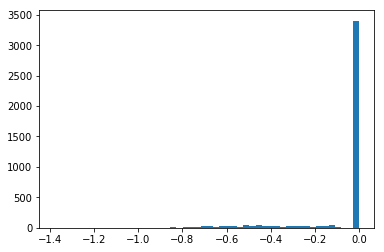

In [41]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=0.20, n_splits=2, random_state = 6).split(df_spec, groups=df_spec['Catalyst Name']))
train = df_spec.iloc[train_inds]
test = df_spec.iloc[test_inds]
X_train_group = train[feature_cols]
y_train_group = train["BindingEnergy"]
X_test_group = test[feature_cols]
y_test_group = test["BindingEnergy"]

model = MLPRegressor(max_iter=20000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
model.fit(X_train_group, y_train_group)

y_pred = model.predict(X_test_group)
plt.hist(df_spec["BindingEnergy"], bins=50)

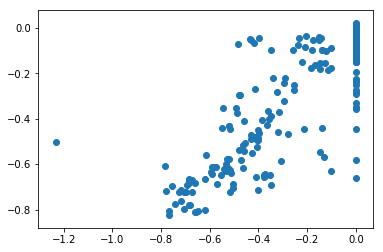

In [44]:
plt.scatter(y_test_group, y_pred)

In [43]:
feature_cols = {"SpinDensity", "ChElPGNeutralCharge", "ChargeDifference", "IonizationEnergy", "OrthoOrPara", "Meta", "FartherThanPara", "DistanceToN", "AverageBondLength",  "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "NeighborSpinDensity", 'NeighborChElPGCharge', 'NeighborChargeDifference', "AromaticExtent", "RingEdge", "NumNitrogens", "NumHeteroatoms", "charge", "atom_plane_deviation", "ring_plane_deviation", "ring_nitrogens"}
not_scaled_cols = {"OrthoOrPara", "Meta", "FartherThanPara", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "RingEdge", "NumNitrogens", "NumHeteroatoms", "ring_nitrogens", "charge"}
df_scale_spec = data_tools.process_data(df_spec, scaledCols=list(feature_cols - not_scaled_cols))
mlp_spec = MLPRegressor(max_iter=20000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
gkf_mse_spec, gkf_mae_spec, df_gkf_spec = group_regression_kfold_evaluate(mlp_spec, df_scale_spec, feature_cols, target_col="BindingEnergy")

/home/nricke/local/opt/miniconda/envs/ds/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nricke/local/opt/miniconda/envs/ds/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Accuracy of RFC on test set: 0.0333
Accuracy of RFC on test set: 0.0288
Accuracy of RFC on test set: 0.0344
Accuracy of RFC on test set: 0.0290
Accuracy of RFC on test set: 0.0287
Accuracy of RFC on test set: 0.0359
Accuracy of RFC on test set: 0.0332
Accuracy of RFC on test set: 0.0406
Accuracy of RFC on test set: 0.0398
Accuracy of RFC on test set: 0.0278
mean: 0.0331471877268142
stdev: 0.004412147766034067


In [45]:
df_gkf_spec

,Unnamed: 0,Atom Number,Catalyst Name,CatalystO2File,Element,SpinDensity,ChElPGPositiveCharge,ChElPGNeutralCharge,ChargeDifference,Doesitbind,...,NeighborChargeDifference,AromaticExtent,RingEdge,NumNitrogens,NumHeteroatoms,ring_nitrogens,atom_plane_deviation,ring_plane_deviation,charge,BindingEnergy_pred
216,216,1,sf117x0,None,C,-0.516954,-0.358097,-0.591682,1.954480,0,...,-1.003252,-1.825482,0,1,2,0,-0.243767,-0.337016,0,0.017214
217,217,3,sf117x0,sf117x0O2-2_optsp_a0m2.out,C,0.802822,-0.082177,-0.613359,-1.917825,1,...,-0.012390,-1.010622,2,1,2,1,0.224170,3.154167,0,-0.570084
218,218,4,sf117x0,None,C,-0.899089,-0.113216,-0.039836,0.260399,0,...,-2.674880,-1.010622,2,1,2,1,-0.213681,3.154167,0,-0.038666
219,219,5,sf117x0,sf117x0O2-4_optsp_a0m2.out,C,2.810003,-0.188779,-1.239317,-2.357371,1,...,0.263116,-1.010622,2,1,2,1,-0.182042,3.154167,0,-0.567988
220,220,6,sf117x0,None,C,-1.373524,0.358312,2.267772,0.797416,0,...,-3.100319,-1.010622,2,1,2,1,-0.243618,3.154167,0,0.037465
221,221,7,sf117x0,sf117x0O2-6_optsp_a0m2.out,C,2.047166,-0.138029,-1.095270,-2.617893,1,...,0.259925,-1.010622,2,1,2,1,1.144744,3.154167,0,-0.737900
297,297,1,sf126x0,None,C,-0.357981,-0.344313,-0.745466,1.295078,0,...,-0.164607,-1.825482,0,2,2,0,-0.243767,-0.337016,0,0.010123
298,298,2,sf126x0,None,C,-0.528253,0.024710,0.504402,0.018486,0,...,0.733040,0.483288,2,2,2,2,-0.243767,-0.337011,0,-0.036093
299,299,3,sf126x0,None,C,-0.042519,0.066858,0.951111,0.800175,0,...,-0.404287,0.483288,1,2,2,2,-0.243754,-0.337011,0,0.033293
300,300,4,sf126x0,sf126x0O2-3_optsp_a0m2.out,C,0.675667,-0.170361,-0.695667,-0.952532,0,...,0.480318,0.483288,2,2,2,2,-0.243738,-0.337011,0,-0.092381


In [40]:
mae = mean_absolute_error(y_test_group, y_pred)
mae

0.06770335606678123

(array([   3.,    3.,    3.,    6.,   18.,   27.,   67.,  389., 2523.,
         363.]),
 array([-2.93006732, -2.61305071, -2.2960341 , -1.97901749, -1.66200089,
        -1.34498428, -1.02796767, -0.71095106, -0.39393446, -0.07691785,
         0.24009876]),
 <a list of 10 Patch objects>)

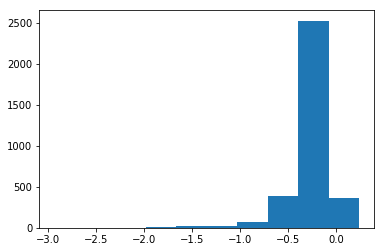

In [28]:
train = df
test = df_inactive
X_train_group = train[feature_cols]
y_train_group = train["BindingEnergy"]
X_test_group = test[feature_cols]
y_test_group = test["BindingEnergy"]

model = MLPRegressor(max_iter=20000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
model.fit(X_train_group, y_train_group)

(array([ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  4.,  3.,  0.,  2.,  3., 16.,
         8., 29., 38., 38., 36., 47., 35., 62., 61., 42., 35., 32., 45.,
        48., 39., 48., 64.]),
 array([-1.37867253, -1.33606727, -1.29346201, -1.25085674, -1.20825148,
        -1.16564622, -1.12304096, -1.0804357 , -1.03783044, -0.99522518,
        -0.95261992, -0.91001466, -0.8674094 , -0.82480414, -0.78219888,
        -0.73959362, -0.69698836, -0.6543831 , -0.61177784, -0.56917258,
        -0.52656732, -0.48396206, -0.4413568 , -0.39875154, -0.35614628,
        -0.31354102, -0.27093575, -0.22833049, -0.18572523, -0.14311997,
        -0.10051471]),
 <a list of 30 Patch objects>)

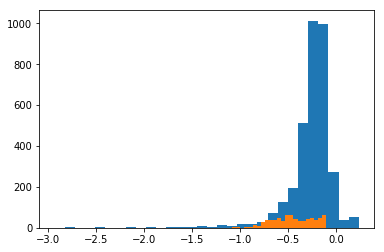

In [32]:
y_pred = model.predict(X_test_group)
plt.hist(y_pred, bins=30)
plt.hist(df["BindingEnergy"], bins=30)

In [22]:
feature_cols = {"SpinDensity", "ChElPGNeutralCharge", "ChargeDifference", "IonizationEnergy", "OrthoOrPara", "Meta", "FartherThanPara", "DistanceToN", "AverageBondLength",  "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "NeighborSpinDensity", 'NeighborChElPGCharge', 'NeighborChargeDifference', "AromaticExtent", "RingEdge", "NumNitrogens", "NumHeteroatoms", "charge", "atom_plane_deviation", "ring_plane_deviation", "ring_nitrogens"}
not_scaled_cols = {"OrthoOrPara", "Meta", "FartherThanPara", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "RingEdge", "NumNitrogens", "NumHeteroatoms", "ring_nitrogens", "charge"}
df_scale = data_tools.process_data(df, scaledCols=list(feature_cols - not_scaled_cols))
mlp = MLPRegressor(max_iter=20000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
gkf_mse, gkf_mae, df_gkf = group_regression_kfold_evaluate(mlp, df_scale, feature_cols, target_col="BindingEnergy")

/home/nricke/local/opt/miniconda/envs/ds/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nricke/local/opt/miniconda/envs/ds/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Accuracy of RFC on test set: 0.0684
Accuracy of RFC on test set: 0.1097
Accuracy of RFC on test set: 0.0657
Accuracy of RFC on test set: 0.0646
Accuracy of RFC on test set: 0.0679
Accuracy of RFC on test set: 0.0740
Accuracy of RFC on test set: 0.0521
Accuracy of RFC on test set: 0.0788
Accuracy of RFC on test set: 0.0689
Accuracy of RFC on test set: 0.0754
mean: 0.07255763888912085
stdev: 0.014166291726136223


In [23]:
df_gkf.columns

Index(['Unnamed: 0', 'Atom Number', 'Catalyst Name', 'CatalystO2File',
       'Element', 'SpinDensity', 'ChElPGPositiveCharge', 'ChElPGNeutralCharge',
       'ChargeDifference', 'Doesitbind', 'BondLength', 'IonizedFreeEnergy',
       'IonizationEnergy', 'BindingEnergy', 'NeutralFreeEnergy', 'OrthoOrPara',
       'Meta', 'FartherThanPara', 'DistanceToN', 'AverageBondLength',
       'BondLengthRange', 'NumberOfHydrogens', 'AromaticSize', 'IsInRingSize6',
       'IsInRingSize5', 'NeighborSpinDensity', 'NeighborChElPGCharge',
       'NeighborChargeDifference', 'AromaticExtent', 'RingEdge',
       'NumNitrogens', 'NumHeteroatoms', 'ring_nitrogens',
       'atom_plane_deviation', 'ring_plane_deviation', 'charge',
       'BindingEnergy_pred'],
      dtype='object')

In [24]:
df_be = df_gkf.sort_values(by="BindingEnergy")[["Catalyst Name", "Atom Number", "BindingEnergy", "BindingEnergy_pred"]]

In [25]:
df_be.to_csv("df_BindingEnergy_pred.csv")

The situation is a little different now than before, as the model has only made predictions on the sites that are known to be active. To really put together both the classification and regression algorithms, we need to make regression predictions for the inactive sites as well.

1. If we don't train on inactive data, what do the predictions on the inactive sites look like?
2. If we set a fixed value for the inactive data and train on that, does that have a negative effect on the accuracy for predicting on the active sites?

In [12]:
def search_for_most_active_sites(df_catalysts, order_col, feature_cols, target_col="Doesitbind", find_num=10):
    """
    df_catalysts (pandas dataframe): catalysts to search
    order_col (str): column name to sort catalysts by. Expected for predict_proba or random values
    """
    df_sort = df_catalysts.sort_values(by=order_col, ascending=False)
    df_best = df_catalysts.sort_values(by="BindingEnergy").head(15) # get strongest binding
    df_best.index

In [75]:
df_ts = df_gkf_spec.copy()
df_ts_best = df_ts.sort_values(by="BindingEnergy").head(15)[["BindingEnergy", "BindingEnergy_pred"]]

df_ts_pred = df_ts.sort_values(by="BindingEnergy_pred")
df_ts_pred = df_ts_pred.assign(pred_rank=range(df_ts_pred.shape[0]))

In [76]:
ts_rr_all = []
nsims = 1000
for j in range(nsims):
    df_ts_rand = df_ts.assign(random_ordering=np.random.rand(df_ts.shape[0]))
    df_ts_rand = df_ts_rand.sort_values(by="random_ordering")
    df_ts_rand = df_ts_rand.assign(rand_rank=range(df_ts_rand.shape[0]))

    ts_pred = df_ts_pred.loc[df_ts_best.index].pred_rank.sort_values()
    ts_rr = df_ts_rand.loc[df_ts_best.index].rand_rank.sort_values()
    ts_rr_pred = []
    for i in range(15):
        ts_rr_pred.append((ts_rr.iloc[i]+1)/(ts_pred.iloc[i]+1))

    ts_rr_all.append(ts_rr_pred)

In [85]:
ts_rr_arr = np.array(ts_rr_all)
ts_mean = np.mean(ts_rr_arr, axis=0)
ts_std = np.std(ts_rr_all, axis=0)

print(ts_mean)
print()
print(ts_std)

[251.938      251.1335     190.98125    206.684      161.026
 171.19511111 112.1881875  108.48       115.79445     49.50586538
  33.26965882  30.866       29.90214286   8.30059447   1.8115164 ]

[2.30487054e+02 1.62354413e+02 9.36430074e+01 8.41326775e+01
 5.65513855e+01 5.34623311e+01 3.07570276e+01 2.59472072e+01
 2.49081149e+01 9.38073379e+00 5.38916854e+00 4.33599167e+00
 3.54415625e+00 7.62934138e-01 1.12907134e-01]


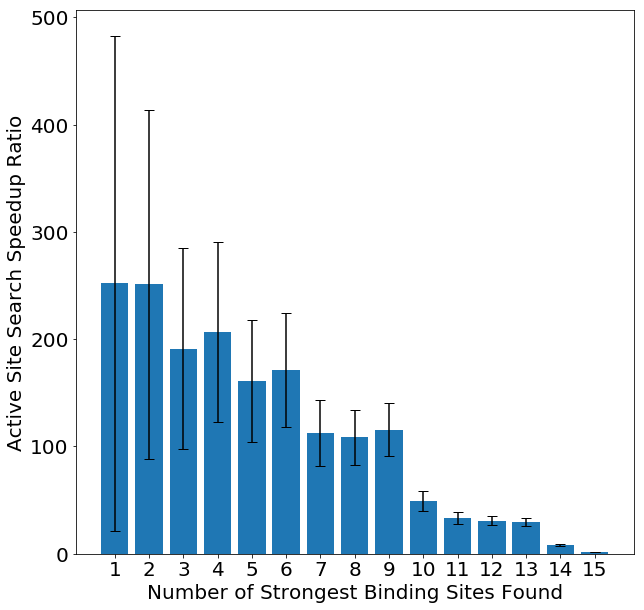

In [106]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.bar(np.arange(15)+1, ts_mean, yerr=ts_std, capsize=5)
plt.xlabel("Number of Strongest Binding Sites Found")
plt.ylabel(r"Active Site Search Speedup Ratio")
ax.set_xticks(np.arange(15)+1)
plt.savefig("ClassRegressionSpeedup.png")

In [68]:

print(ts_rr.iloc[4], ts_rr.iloc[9])

1218 2592


In [71]:
ts_rr_pred = []
for i in range(15):
    ts_rr_pred.append((ts_rr.iloc[i]+1)/(ts_pred.iloc[i]+1))

[194.0,
 286.5,
 204.5,
 232.4,
 152.375,
 150.22222222222223,
 146.5625,
 127.10526315789474,
 124.2,
 49.86538461538461,
 34.56470588235294,
 30.76,
 28.151785714285715,
 7.988479262672811,
 1.8809746954076851]

In [ ]:
# for each index in df_ts_best
# 

In [16]:
l_O2, c_O2 = search_for_active_catalysts(df_ts, order_col="random_ordering", feature_cols=feature_cols, find_num=100)
print(len(l_O2), c_O2)
l_t, c_t = search_for_active_catalysts(df_ts, order_col="Doesitbind_predproba", feature_cols=feature_cols, find_num=100)
print(len(l_t), c_t)

100 607
100 101
